In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import matplotlib.pyplot as plt 
from PIL import Image , ImageDraw 
from sklearn.preprocessing import * 
import time 
import ast 
import os 
import keras 
import tensorflow as tf 
from keras import models, layers 
from keras import Input 
from keras.models import Model, load_model 
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers, initializers, regularizers, metrics 
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.layers import BatchNormalization, Conv2D, Activation , AveragePooling2D , Input ,Dropout 
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Flatten 
from keras.models import Sequential 
from keras.metrics import top_k_categorical_accuracy 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
from keras.applications import ResNet50, vgg19,mobilenet_v2,InceptionV3 , InceptionResNetV2,DenseNet169 
from tqdm import tqdm 
import cv2

In [2]:
path ='C:/Users/sdf80/Desktop/fruit_dataset/TotalClass/'
filename = os.listdir(path)
datalist = pd.DataFrame(data=[], columns=['label','img'])

label = []
img = []

for file in tqdm(filename):
    label.append(file.split('.')[0])
    img.append(file)
    
datalist['label'] = label
datalist['img'] = img

datalist.head()

100%|████████████████████████████████████████████████████████████████████████████| 940/940 [00:00<00:00, 478476.43it/s]


,label,img
0,BackBad,BackBad.0.jpg
1,BackBad,BackBad.1.jpg
2,BackBad,BackBad.10.jpg
3,BackBad,BackBad.100.jpg
4,BackBad,BackBad.101.jpg


No handles with labels found to put in legend.


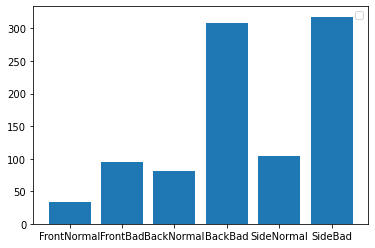

In [3]:
FrontNormalNum = 0 
FrontBadNum = 0
BackNormalNum = 0 
BackBadNum = 0
SideNormalNum = 0
SideBadNum = 0

for i in datalist['label']:
    if i == 'FrontNormal':
        FrontNormalNum += 1
    if i == 'FrontBad':
        FrontBadNum += 1
    if i == 'BackNormal':
        BackNormalNum += 1
    if i == 'BackBad':
        BackBadNum += 1
    if i == 'SideNormal':
        SideNormalNum += 1
    if i == 'SideBad':
        SideBadNum += 1    
        
plt.bar(['FrontNormal', 'FrontBad', 'BackNormal', 'BackBad', 'SideNormal', 'SideBad'], [FrontNormalNum, FrontBadNum, BackNormalNum, BackBadNum, SideNormalNum, SideBadNum])
plt.legend()

In [16]:
print('FrontNormal Count')
print(datalist[datalist['label'] =='FrontNormal']['label'].count())

print('FrontBad Count')
print(datalist[datalist['label'] =='FrontBad']['label'].count())

print('BackNormal Count')
print(datalist[datalist['label'] =='BackNormal']['label'].count())

print('BackBad Count')
print(datalist[datalist['label'] =='BackBad']['label'].count())

print('SideNormal Count')
print(datalist[datalist['label'] =='SideNormal']['label'].count())

print('SideBad Count')
print(datalist[datalist['label'] =='SideBad']['label'].count())

print('Total Count')
print(datalist['label'].count())

FrontNormal Count
34
FrontBad Count
95
BackNormal Count
81
BackBad Count
308
SideNormal Count
104
SideBad Count
318
Total Count
940


In [4]:
def preprocessing(path) :
    X = []
    Y = []
    class_label = []
    class_num = 6
    
    for num in tqdm(range(len(datalist['img']))) :
        img = cv2.imread(path+datalist['img'][num])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(160,160))
        
        if datalist['label'][num] == 'FrontNormal': 
            X.append(img) 
            Y.append(0) 
        elif  datalist['label'][num] == 'FrontBad': 
            X.append(img) 
            Y.append(1)
        elif  datalist['label'][num] == 'BackNormal': 
            X.append(img) 
            Y.append(2)
        elif  datalist['label'][num] == 'BackBad': 
            X.append(img) 
            Y.append(3)
        elif  datalist['label'][num] == 'SideNormal': 
            X.append(img) 
            Y.append(4)
        else:
            X.append(img) 
            Y.append(5)

    tmpx = np.array(X) 
    Y = np.array([[i] for i in Y]) 
    enc = OneHotEncoder(categories='auto') 
    enc.fit(Y) 
    tmpy = enc.transform(Y).toarray() 

    del X 
    del Y #RAM메모리 절약을 위해 사용하지 않는 변수 삭제
    return tmpx , tmpy , class_label , class_num

In [5]:
tmpx, tmpy, class_label, class_num = preprocessing(path) 
#파일이름이 담긴 배열 
print(tmpx.shape, tmpy.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 940/940 [00:02<00:00, 340.11it/s]


(940, 160, 160, 3) (940, 6)


In [6]:
from sklearn.model_selection import train_test_split 
X_train, X_val, Y_train, Y_val = train_test_split(tmpx,tmpy, test_size = 0.2,random_state = 1) 
del tmpx 
del tmpy #RAM메모리 절약을 위해 사용하지 않는 변수 삭제 

print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(752, 160, 160, 3) (188, 160, 160, 3) (752, 6) (188, 6)


In [7]:
nb_train_samples = len(X_train) 
nb_validation_samples = len(X_val) 
batch_size = 2
train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 

val_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 

train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size) 
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

In [8]:
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import RMSprop

pre_trained_model = InceptionV3(input_shape=(160, 160, 3),
                              include_top=False,
                              weights=None)
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(6, activation='softmax')(x)

model2 = Model(pre_trained_model.input, x)

model2.compile(optimizer='adam',   #RMSprop(lr=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
history = model2.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=60,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
376/376 [==============================] - 304s 809ms/step - loss: 6.5506 - accuracy: 0.4707 - val_loss: 1.2030 - val_accuracy: 0.6117
Epoch 2/60
376/376 [==============================] - 301s 801ms/step - loss: 1.0877 - accuracy: 0.6117 - val_loss: 1.1193 - val_accuracy: 0.6117
Epoch 3/60
376/376 [==============================] - 306s 813ms/step - loss: 1.0197 - accuracy: 0.6316 - val_loss: 0.9390 - val_accuracy: 0.6489
Epoch 4/60
376/376 [==============================] - 299s 794ms/step - loss: 0.9722 - accuracy: 0.6370 - val_loss: 1.0205 - val_accuracy: 0.6223
Epoch 5/60
376/376 [==============================] - 277s 738ms/step - loss: 0.9730 - accuracy: 0.6436 - val_loss: 0.9274 - val_accuracy: 0.6489
Epoch 6/60
376/376 [==============================] - 277s 736ms/step - loss: 1.0030 - accuracy: 0.6343 - val_loss: 1.0237 - val_accuracy: 0.6489
Epoch 7/60
376/376 [============================

376/376 [==============================] - 303s 806ms/step - loss: 0.5005 - accuracy: 0.8045 - val_loss: 0.7599 - val_accuracy: 0.7287
Epoch 56/60
376/376 [==============================] - 11199s 30s/step - loss: 0.4540 - accuracy: 0.8231 - val_loss: 0.7274 - val_accuracy: 0.7819
Epoch 57/60
376/376 [==============================] - 304s 809ms/step - loss: 0.4345 - accuracy: 0.8258 - val_loss: 0.5119 - val_accuracy: 0.7819
Epoch 58/60
376/376 [==============================] - 304s 808ms/step - loss: 0.4315 - accuracy: 0.8258 - val_loss: 0.4756 - val_accuracy: 0.8138
Epoch 59/60
376/376 [==============================] - 303s 807ms/step - loss: 0.4520 - accuracy: 0.8231 - val_loss: 0.5597 - val_accuracy: 0.7979
Epoch 60/60
376/376 [==============================] - 304s 808ms/step - loss: 0.4440 - accuracy: 0.8258 - val_loss: 0.5132 - val_accuracy: 0.7872


In [10]:
from keras.models import load_model

model2.save('Fruit_MultiClassification_Model.h5')